# Chapter 7 - Relationships between variables

## Reading

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np


import thinkstats2
import thinkplot

In [3]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [4]:
import brfss


df = brfss.ReadBrfss(nrows=None)

In [6]:
df.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
2,48.0,2,NaN,181.063210,NaN,165.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0


Scatter plots:

In [5]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

In [7]:
sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

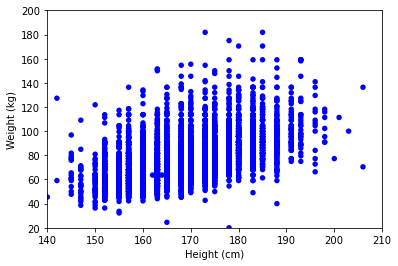

In [8]:
thinkplot.Scatter(heights, weights, alpha=1)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

In [13]:
def Jitter(values, jitter=0.5, distr='normal'):
    n = len(values)
    if distr == 'normal':
        return np.random.normal(0, jitter, n) + values
    elif distr == 'uniform':
        return np.random.uniform(-jitter, +jitter, n) + values
    else:
        raise RuntimeError(f"`distr` must be 'normal' or 'uniform', not {distr}.")

Heights were probably rounded off to the nearest inch, which is 2.6 cm, so I'll add random values from -1.3 to 1.3.

In [14]:
heights = Jitter(heights, 1.3)
weights = Jitter(weights, 0.5)

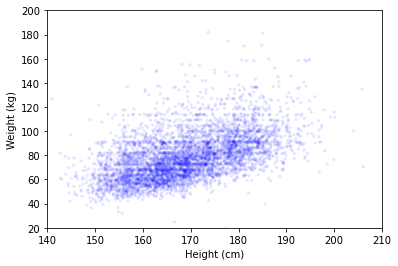

In [16]:
thinkplot.Scatter(heights, weights, alpha=0.1, s=10)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

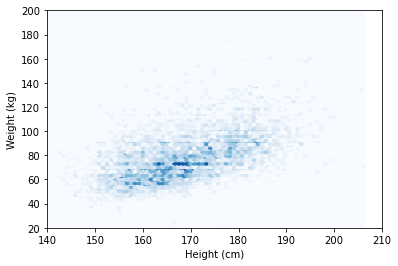

In [17]:
thinkplot.HexBin(heights, weights)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatter plot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

In [18]:
all_heights, all_weights = df.htm3, df.wtkg2

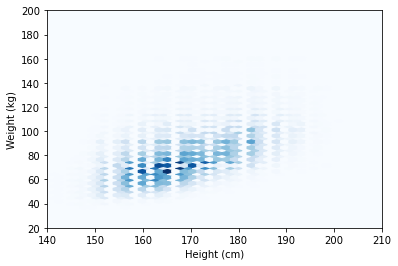

In [19]:
thinkplot.HexBin(all_heights, all_weights)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

In [20]:
all_heights_jitter, all_weights_jitter = Jitter(all_heights, 1.3), Jitter(all_weights, 0.5)

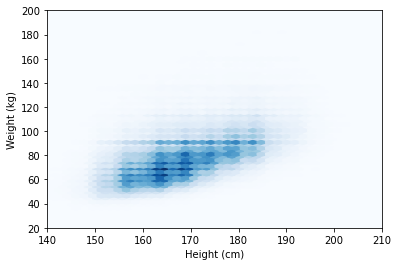

In [21]:
thinkplot.HexBin(all_heights_jitter, all_weights_jitter)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

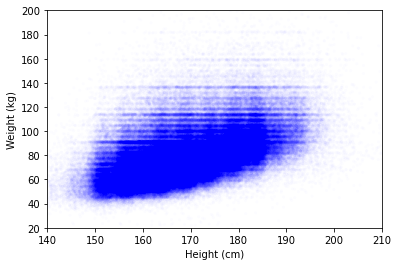

In [23]:
thinkplot.Scatter(all_heights_jitter, all_weights_jitter, alpha=0.01, s=10)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

We need datashader.

Plotting percentiles:

In [24]:
cleaned = df.dropna(subset=['htm3', 'wtkg2'])

In [25]:
# Bin by height
bins = np.arange(135, 210, 5)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)

In [26]:
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

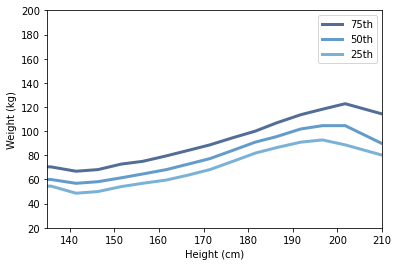

In [31]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = f'{percent}th'
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[135, 210, 20, 200],
                 legend=True)

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

In [39]:
bins

array([135, 160, 185])

In [33]:
# Bin by height
bins = np.arange(135, 210, 25)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)

In [48]:
bins

array([135, 160, 185])

In [50]:
for i, group in groups:
    print(i, group.htm3.mean())

0 120.12459016393443
1 154.5116120319943
2 170.27823979917173
3 188.65341022071982


In [51]:
cdfs = [thinkstats2.Cdf(group.wtkg2, label=f'height group {i}') for i, group in groups]

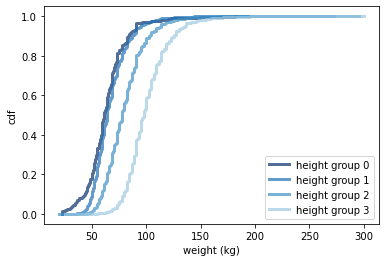

In [52]:
thinkplot.Cdfs(cdfs)
thinkplot.Config(xlabel='weight (kg)', ylabel='cdf', legend=True)

Correlation:

In [53]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

In [54]:
heights, weights = cleaned.htm3, cleaned.wtkg2
Cov(heights, weights)

103.33290857697797

In [55]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

In [56]:
Corr(heights, weights)

0.5087364789734665

In [57]:
np.corrcoef(heights, weights)

array([[1.        , 0.50873648],
       [0.50873648, 1.        ]])

In [58]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

In [59]:
SpearmanCorr(heights, weights)

0.5405846262320475

We can also use a built-in Pandas Series method to compute the Spearman correlation.

In [60]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

We can transform one or both of the variables to make the relationship closer to linear and then compute Pearson's correlation:

In [61]:
Corr(cleaned.htm3, np.log(cleaned.wtkg2))

0.5317282605983543

# Exercises

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?


In [62]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [63]:
import first

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [64]:
live.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


In [65]:
mother_age = live.agepreg
birth_weight = live.totalwgt_lb

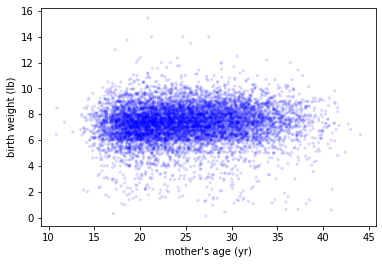

In [70]:
thinkplot.Scatter(mother_age, birth_weight, alpha=0.15, s=10)
thinkplot.Config(xlabel="mother's age (yr)",
                 ylabel='birth weight (lb)',
                 legend=False)

In [97]:
Corr(mother_age, birth_weight)

0.06883397035410911

In [98]:
SpearmanCorr(mother_age, birth_weight)

0.09461004109658226

In [82]:
# Bin by mother's age
bins = np.arange(10, 45, 5)
indices = np.digitize(mother_age, bins)
groups = live.groupby(indices)

In [95]:
mean_age = [group.agepreg.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups]

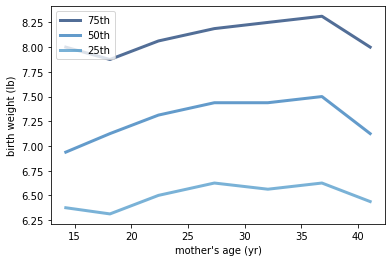

In [96]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = f'{percent}th'
    thinkplot.Plot(mean_age, weight_percentiles, label=label)
    
thinkplot.Config(xlabel="mother's age (yr)",
                 ylabel='birth weight (lb)',
                 legend=True)